# Sematical Parsing of Web Pages

The pool of information on the internet is increasing constantly, which makes it difficult for normal users to crawl out the important information. This dataset (hyperlink here) is meant to parse out the relevant content of a website into a textual format, making it easy for users to understand the information.

Possible use case - Preprocessing of unstructured data for NLP tasks, such as - automated summarization, Q&A tool, Topic Modelling.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

In [38]:
dataset = pd.read_csv('Data/dataset.csv')

In [39]:
dataset.describe()

,Fraction Formatting Tags,Num Formatting Tags,Fraction Words,Num Words,Fraction p Children,Label
count,2486.000000,4243.000000,2486.000000,4243.000000,4243.000000,4243.000000
mean,1.087703,0.031995,0.917168,0.024311,0.004398,0.005185
std,2.210455,0.136752,2.593583,0.102977,0.051789,0.071829
min,0.000000,0.000000,0.028256,0.000126,0.000000,0.000000
25%,0.000000,0.000000,0.293834,0.000425,0.000000,0.000000
50%,0.000000,0.000000,0.525802,0.001110,0.000000,0.000000
75%,1.689977,0.004405,0.781277,0.003396,0.000000,0.000000
max,29.694444,1.000000,87.109635,0.999073,1.000000,1.000000


The dataset has 6 columns - 5 predictor and 1 output column. Below is a description of each column - 

- Fraction Formatting Tags: This describes the fraction of formatting tags that are present in the descendents of the current html tag.
- Num Formatting Tags: This describes the fraction of total formatting tags in the html document, that are in the current html tag.
- Fraction Words: This describes the ratio of words to the total tags contained in the current html tag.
- Num Words: This describes the ratio of number of words in the current html tag to the total number of words in the html document.
- Fraction p Children: This describes the ratio of number of 'p' tags that are direct children to the current html tag, to the total number of 'p' tags in the entire document.

What are formatting tags? Tags such as 'p', 'b', 'i', 'strong' are counted as formatting tags.

For more information on the data, please have a look at the data gatherer at my github (hyperlink here) repository (development branch)

In [40]:
dataset['Label'].value_counts()

0    4221
1      22
Name: Label, dtype: int64

This is a highly imbalanced dataset!

In [171]:
sns.__version__

'0.9.0'

## Exploratory Data Analysis

Let's look at pairplots in order to get an idea of the pairs of predictors which strongly discriminate the outcomes.

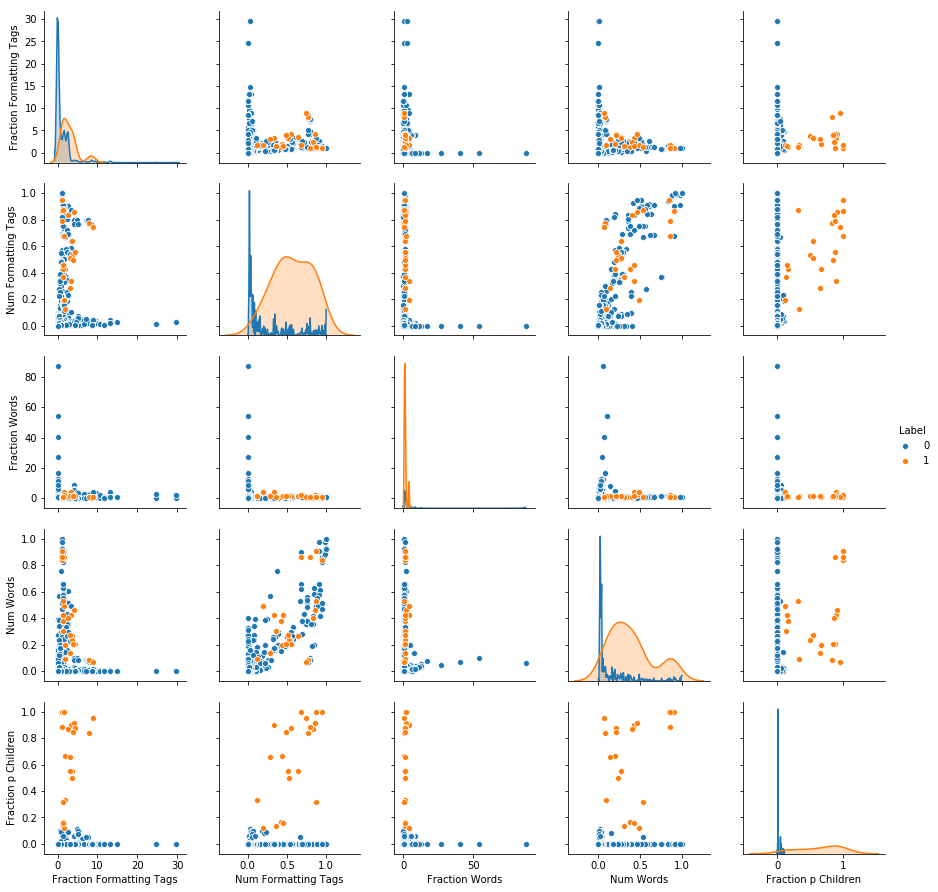

In [164]:
sns.pairplot(dataset, vars = ['Fraction Formatting Tags', 'Num Formatting Tags', 'Fraction Words', 'Num Words', 'Fraction p Children'], hue = 'Label')

From the above pairplots, it is quite certain that __Fraction p Children__ is a quite huge factor in determining the necessity of a tag. However, there are parts where the distinction seems to be very blurry. I believe __Num Words__ will be very useful in such situations.

Let's look if there is a clear demarcation between the unnecessary and necessary tags in terms of the feature

In [43]:
high_fpc_unnecessary = dataset.loc[(dataset['Label'] == 0) & (dataset['Fraction p Children'] > 0.08)]

In [44]:
high_fpc_unnecessary

,Fraction Formatting Tags,Num Formatting Tags,Fraction Words,Num Words,name,attrs,Fraction p Children,Label
364,4.784483,0.034483,2.179480,0.015708,div,"{'class': ['success-messaging', 'ui-hidden']}",0.111111,0
398,0.656126,0.036364,0.486584,0.026967,div,{'id': 'document-footer-content'},0.100000,0
441,2.219251,0.181818,0.307575,0.025199,div,{'class': ['byline-social']},0.100000,0
1881,1.742750,0.204082,1.248927,0.146253,section,"{'id': 'ref60691', 'data-level': '1'}",0.083333,0
1968,0.782609,0.042553,0.497283,0.027039,div,{'id': 'document-footer-content'},0.090909,0
2014,2.675676,0.234043,0.304054,0.026596,div,{'class': ['byline-social']},0.090909,0
2724,5.184211,0.070175,0.300061,0.004062,div,{'class': ['column4']},0.094595,0


In [45]:
low_fpc_necessary = dataset.loc[(dataset['Label'] == 1) & (dataset['Fraction p Children'] < 0.2)]

In [46]:
low_fpc_necessary

,Fraction Formatting Tags,Num Formatting Tags,Fraction Words,Num Words,name,attrs,Fraction p Children,Label
1056,1.251458,0.430233,1.105749,0.380140,td,{},0.166667,1
2536,1.447531,0.365517,1.196204,0.302054,td,{},0.131868,1
2954,1.629323,0.192982,4.132268,0.489439,td,{},0.121622,1
3349,1.451742,0.454545,1.358847,0.425460,td,{},0.154639,1


It seems that __Num Formatting Tags__ and __Num Words__ add appreciable distinction in the border cases of __Fraction p Children__. One, or both of these, may be used along with __Fraction p Children__ for better results.

Let's now fit a Logistic Regression model to the data and see the outcome. However, I will verify if the assumption - "__The log odds of success varies linearly with the independent variables__".
The above assumption states that the probability of getting on of the class will linearly increase with the independent variables.

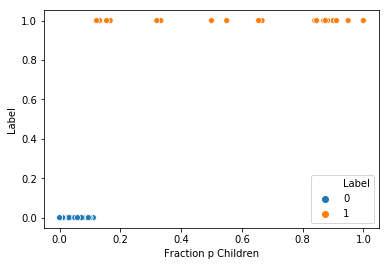

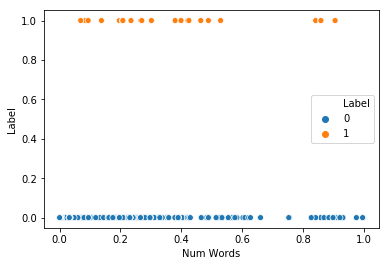

In [48]:
sns.scatterplot(x = 'Fraction p Children', y = 'Label', hue = 'Label', data = dataset)
plt.show()
sns.scatterplot(x = 'Num Words', y = 'Label', hue = 'Label', data = dataset)
plt.show()

__Fraction p Children__ does abide by the assumption for Logistic Regression. However, __Num Words__ doesn't seem to do so. Let's see if a convolution of __Num Words__ and __Fraction p Children__ seems to abide by it.

In [153]:
dataset['Add'] = dataset.apply(lambda row: row['Fraction p Children'] + row['Num Words'], axis = 1)
dataset['Multiply'] = dataset.apply(lambda row: row['Fraction p Children'] * row['Num Words'], axis = 1)

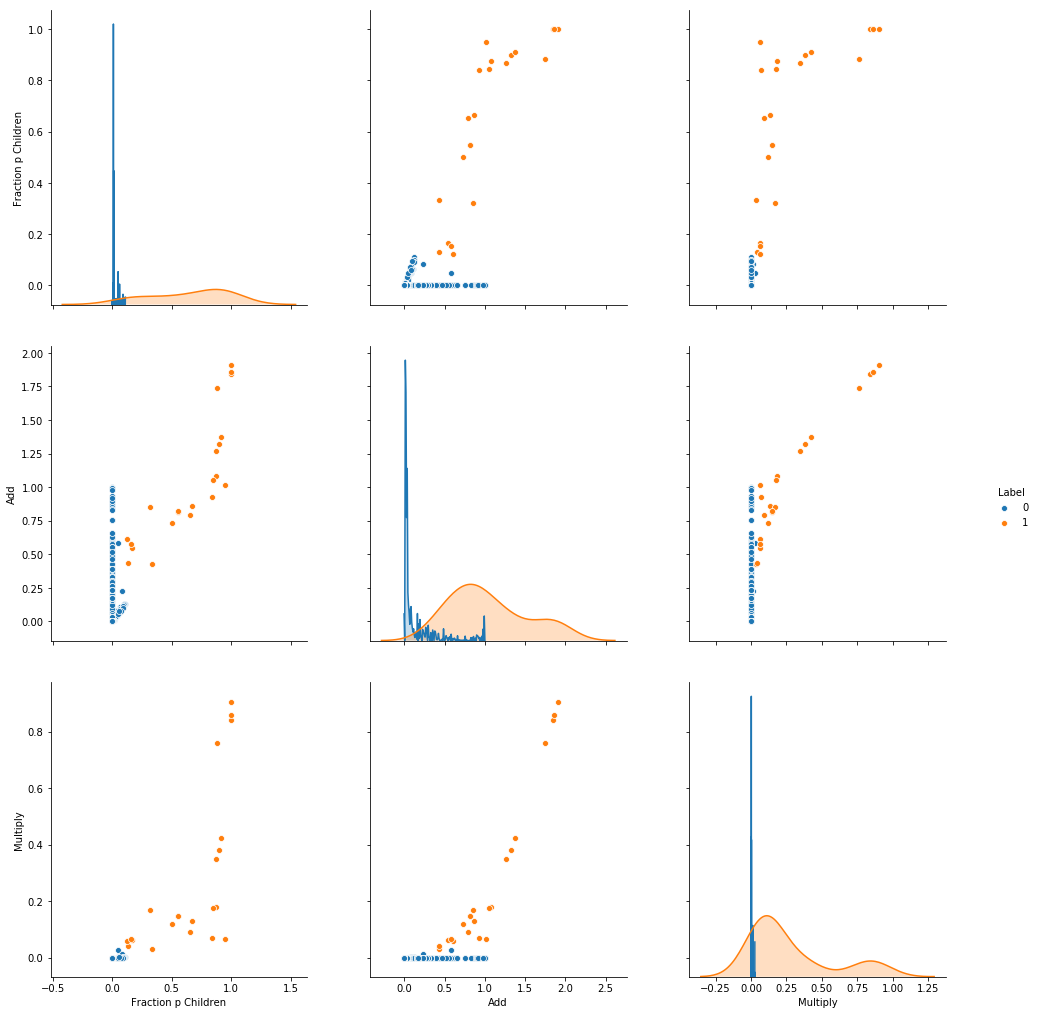

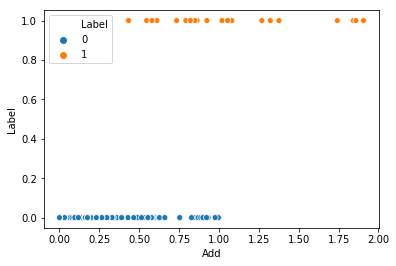

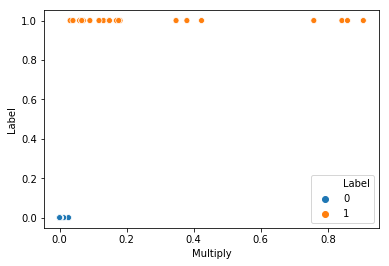

In [159]:
# plt.figure(figsize = (30, 25))
g = sns.pairplot(dataset, vars = ['Fraction p Children', 'Add', 'Multiply'], hue = 'Label')
g.fig.set_size_inches(15,15)
plt.show()
sns.scatterplot(x = 'Add', y = 'Label', hue = 'Label', data = dataset)
plt.show()
sns.scatterplot(x = 'Multiply', y = 'Label', hue = 'Label', data = dataset)
plt.show()

Both multiplication and addition do tend to create a better variable than __Num Words__ itself (abiding better by the assumption of Logistic Regression), keeping the discrimation power unhindered. I will be using the additive interaction for further analysis, as it does seem to have some better discriminatory power than multiplication.

## Model Fitting

### Plain Sigmoid Curve

Let's fit a sigmoid curve to the data with __Fraction p Children__ and __Add__ (addition of the two I.V.) as the predictors. 

In [87]:
def sigmoid(X, theta_1, theta_2, a, b):
    X_1, X_2 = X
    return 1/(1 + np.exp(-a * (theta_1 * X_1 + theta_2 * X_2 - b)))

In [98]:
params_optimal[0] * pseudo_X_1 + params_optimal[1] * pseudo_X_2

array([ 0.        ,  1.61187376,  3.22374752,  4.83562128,  6.44749504,
        8.0593688 ,  9.67124255, 11.28311631, 12.89499007, 14.50686383])

/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


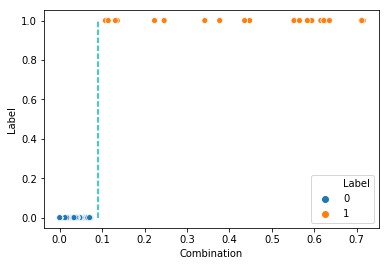

In [160]:
X_1 = dataset['Fraction p Children'].values
X_2 = dataset['Add'].values
y = dataset['Label'].values

params_optimal, _ = optimize.curve_fit(sigmoid, xdata = (X_1, X_2), ydata = y, p0 = (1, 1, 100, 0.5))

pseudo_X_1 = np.arange(0, 1, 0.1)
pseudo_X_2 = np.arange(0, 1, 0.1)
y_proba = sigmoid((pseudo_X_1, pseudo_X_2), *params_optimal)

dataset['Combination'] = dataset.apply(lambda row: params_optimal[0] * row['Fraction p Children'] 
                                       + params_optimal[1] * row['Add'], axis = 1)

sns.scatterplot(x = 'Combination', y = 'Label', hue = 'Label', data = dataset)
plt.vlines(0.09, ymin = 0, ymax = 1, linestyle = '--', color = 'c')
plt.legend()

It can be seen that fitting a simple sigmoid curve to the data would give a very good result - with threshold set around the vertical line drawn in the plot. Hence, I would be using a Logistic Regression model with __Fraction p Children__ and __Add__ predictors.

### Logistic Regression

/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


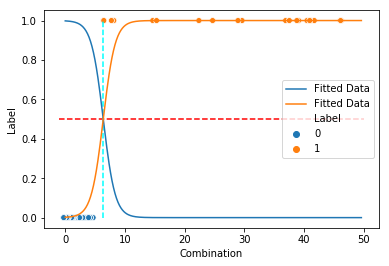

In [152]:
X = dataset.loc[:, ['Fraction p Children', 'Add']]
y = dataset['Label'].values

sc_fp = StandardScaler()
sc_m = StandardScaler()
X.iloc[:, 0] = sc_fp.fit_transform(X.iloc[:, 0].values.reshape(-1, 1))
X.iloc[:, 1] = sc_m.fit_transform(X.iloc[:, 1].values.reshape(-1, 1))

model = LogisticRegression().fit(X, y)

theta_1, theta_2 = model.coef_[0]

dataset['Combination'] = theta_1 * sc_fp.transform(dataset['Fraction p Children'].values.reshape(-1, 1)) + theta_2 * sc_m.transform(dataset['Add'].values.reshape(-1, 1))

pseudo_X_1 = np.arange(0, 20, 0.05)
pseudo_X_2 = np.arange(0, 20, 0.05)
combination = theta_1 * pseudo_X_1 + theta_2 * pseudo_X_2

X_test = pd.DataFrame()
X_test['Fraction p Values'] = pseudo_X_1
X_test['Add'] = pseudo_X_2

y_proba = model.predict_proba(X_test.values)

sns.scatterplot(x = 'Combination', y = 'Label', data = dataset, hue = 'Label')
plt.plot(combination, y_proba, label = 'Fitted Data')
plt.hlines(y = 0.5, xmin = -1, xmax = 50, linestyle = '--', color = 'red')
plt.vlines(x = 6.4, ymin = 0, ymax = 1, linestyle = '--', color = 'cyan')
plt.legend()

## Conclusions

You can see that the model has well fitted to the data. This model can now be used to predict!

Some important pointers - 
- You might want to collect data near and around the threshold (~6.4) for __Fraction p Children__, in order to make the prediction more reliable.
- Important features - __Num Words__ and __Fraction p Children__